# Model Selection
This section entails various different models: linear, neural network, and tree-based, and explores the possibility of ensembling through stacking to attain a higher r2 score. Refer to the notebook titled Fine-Tuning-i5-Cities-And-Airfields to see the model tuning procedure. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_validation import train_test_split, cross_val_score
import xgboost as xgb
from pylightgbm.models import GBMRegressor
from mlxtend.regressor import StackingRegressor

warnings.filterwarnings('ignore')
%matplotlib inline
kc_data = pd.read_csv('ci_i5_ap.csv')
pd.set_option('display.max_columns', None)

SEED=42
CV_FOLDS=10

/usr/local/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
kc_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_purch,mnth_purch,i5_dist,distSeattle,durSeattle,distBellevue,durBellevue,distRedmond,durRedmond,distBF,distRA,distSeaTac
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,5877.622101,21.5,23.0,28.5,26.0,41.5,35.0,12688.469538,11991.444291,26486.130761
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,1312.366989,11.5,16.0,21.5,21.0,31.9,26.0,70456.156047,86919.754992,101345.182916
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,22578.916422,33.7,31.0,20.9,22.0,15.1,25.0,78351.560666,89424.461864,108475.592537
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,21931.464273,18.8,25.0,27.1,30.0,40.0,39.0,22694.351785,44762.368937,36974.265724
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,68342.455394,35.2,34.0,22.5,25.0,10.2,16.0,71154.105069,61925.773807,88541.576510


In [3]:
kc_data = kc_data.drop(['id', 'date'], axis=1)
kc_data.head()
kc_data['price'] = np.log(kc_data['price'])
kc_train, kc_test, train_Y, test_Y = train_test_split(
    kc_data, kc_data['price'], 
    test_size=.25, 
    random_state=SEED
)
kc_train = kc_train.drop('price', axis=1)
kc_test = kc_test.drop('price', axis=1)

In [4]:
scaler = StandardScaler()
kc_train = scaler.fit_transform(kc_train)
kc_test = scaler.transform(kc_test)

### ElasticNet

In [5]:
reg_elastic = ElasticNet(alpha=0.0015, l1_ratio=0.14, tol=0.00001)

In [512]:
cv = cross_val_score(reg_elastic, kc_train, train_Y, cv=CV_FOLDS)
cv.mean()
#0.85712707533375476

0.85712707533375476

In [513]:
def plot_learning_curves(title, train_sizes, train_scores, valid_scores, ylim=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color="g", label="Cross-Valid Score")
    plt.legend(loc="best")
    plt.show()

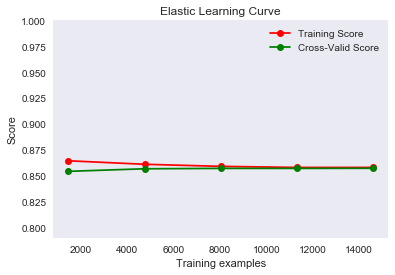

In [524]:
elastic_sizes, elastic_train_scores, elastic_valid_scores = learning_curve(
    reg_elastic, 
    kc_train, 
    train_Y, 
    train_sizes=np.linspace(0.1, 1.0, 5.0, 10.0), 
    scoring='r2',
    cv=CV_FOLDS
)
plot_learning_curves('Elastic Learning Curve', elastic_sizes, elastic_train_scores, elastic_valid_scores, (.79, 1.0))

In [210]:
unscaled_elastic = ElasticNet(alpha=0.0015, l1_ratio=0.2, tol=0.1)
unscaled_cv = cross_val_score(unscaled_elastic, kc_train, train_Y, cv=CV_FOLDS)
print(unscaled_cv.mean())

0.823655554881


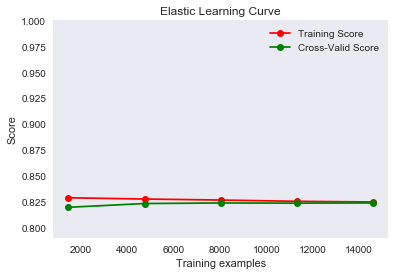

In [523]:
elastic_sizes, elastic_train_scores, elastic_valid_scores = learning_curve(unscaled_elastic, kc_train, train_Y, train_sizes=np.linspace(0.1, 1.0, 5.0, 10.0), cv=CV_FOLDS)
plot_learning_curves('Elastic Learning Curve', elastic_sizes, elastic_train_scores, elastic_valid_scores, (.79, 1.0))

In [28]:
gbm = xgb.XGBRegressor(
    min_child_weight=5, 
    max_depth=3, 
    objective='reg:linear',
    gamma=0.05,
    reg_alpha=0.6,
    reg_lambda=1,
    learning_rate=0.1, 
    colsample_bytree=1.0, 
    seed=SEED, 
    n_estimators=2275, 
    subsample=1,
    verbose=True
)

In [29]:
gbm_cv = cross_val_score(gbm, kc_train, train_Y, cv=CV_FOLDS)
gbm_cv.mean()

#0.91019655933777766

0.90856775643441912

In [ ]:
gbm_sizes, gbm_train_scores, gbm_valid_scores = learning_curve(gbm, kc_train, train_Y, train_sizes=np.linspace(0.1, 1.0, 5.0, 10.0), scoring='r2',cv=CV_FOLDS)
plot_learning_curves('XGB Learning Curve', gbm_sizes, gbm_train_scores, gbm_valid_scores, (.79, 1.0))

In [ ]:
gbm_sizes, gbm_train_scores, gbm_valid_scores = learning_curve(gbm, kc_train, train_Y, train_sizes=np.linspace(0.1, 1.0, 5.0, 10.0), scoring='r2',cv=CV_FOLDS)
plot_learning_curves('XGB Learning Curve', gbm_sizes, gbm_train_scores, gbm_valid_scores, (.79, 1.0))

In [ ]:
# import xgboost as xgb
# gbm = xgb.XGBRegressor(n_estimators=2275, seed=SEED)
# gbm_cv = cross_val_score(gbm, kc_train, train_Y, cv=CV_FOLDS)

### AdaBoost

In [7]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=16), n_estimators=1000, random_state=SEED)

In [222]:
gbm_ada = cross_val_score(ada_reg, kc_train, train_Y, cv=CV_FOLDS)
gbm_ada.mean()

0.89201467162787051

### +Yard Size

In [250]:
kc_data['sqft_yard'] = kc_data['sqft_lot15']-(kc_data['sqft_living15']/kc_data['floors'])

In [481]:
nf_train, nf_test, nf_Y, nf_tY = train_test_split(kc_data, kc_data['price'], test_size=.25, random_state=SEED)
nf_train = nf_train.drop('price', axis=1)
nf_train = nf_train.drop('lot_liv_ratio', axis=1)
nf_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_purch,mnth_purch,i5_dist,distSeattle,durSeattle,distBellevue,durBellevue,distRedmond,durRedmond,distBF,distRA,distSeaTac,sqft_yard
5945,4,2.25,1810,9240,2.0,0,0,3,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240,2015,5,20153.336406,33.8,32.0,22.5,22.0,34.6,30.0,43954.344008,21974.231182,27133.800373,8410.0
8423,3,2.50,1600,2788,2.0,0,0,4,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605,2014,7,23292.963511,38.0,35.0,26.2,27.0,38.3,35.0,53652.772032,33493.295825,30731.498973,2745.0
13488,4,2.50,1720,8638,2.0,0,0,3,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455,2015,1,808.448345,46.6,37.0,45.2,35.0,57.3,42.0,94075.842148,84634.687722,63314.554639,6520.0
20731,2,2.25,1240,705,2.0,0,0,3,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750,2015,4,49670.860177,32.0,30.0,17.6,18.0,28.1,26.0,56542.604803,38246.781955,63912.617052,130.0
2358,3,2.00,1280,13356,1.0,0,0,3,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071,2014,12,53570.507120,66.9,52.0,42.0,43.0,54.1,51.0,80273.937377,56655.444658,60961.791816,6481.0


In [252]:
gbm_cv = cross_val_score(gbm, nf_train, train_Y, cv=CV_FOLDS)
gbm_cv.mean()

0.90791221908095865

### Neural Network

In [8]:
reg_nn = MLPRegressor(hidden_layer_sizes=(20,20,50,20,20),random_state=SEED)

In [673]:
cv_nn = cross_val_score(reg_nn, kc_train, train_Y, cv=CV_FOLDS)
cv_nn.mean()

0.85194368399349685

### Light GBM

In [9]:
home = os.path.expanduser("~")
exec = os.path.join(home, "LightGBM/lightgbm")

lgbm = GBMRegressor(exec_path=exec, 
                    boosting_type='gbdt',
                    feature_fraction_seed=SEED,
                    bagging_seed=SEED,
                    tree_learner='serial',
                    metric='r2', #l2
                    verbose=False,
                    
                    num_leaves=35,
                    num_iterations=3800,#350 faster1
                    learning_rate=0.01,#0.1 faster1
                    max_bin=500, #255 faster1

                    min_data_in_leaf=5,
                    feature_fraction=1,

                    bagging_fraction=1,
                    bagging_freq=10,

                    metric_freq=1,
                    early_stopping_round=19
                   )

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


In [ ]:
lgbm_cv = cross_val_score(lgbm, kc_train, train_Y, cv=CV_FOLDS)

In [648]:
lgbm_cv.mean()
# 0.90887468125246662
# 0.90953030499443321

0.90953030499443321

In [678]:
# lgbm_high_iter_score=0
# lgbm_iter=0
# for i in range(2225, 3500, 25):
#     lgbm = GBMRegressor(exec_path=exec, 
#                         boosting_type='gbdt',
#                         feature_fraction_seed=SEED,
#                         bagging_seed=SEED,
#                         tree_learner='serial',
#                         metric='r2', #l2
#                         verbose=False,

#                         num_leaves=35,
#                         num_iterations=i,#350 faster1
#                         learning_rate=0.01,#0.1 faster1
#                         max_bin=500, #255 faster1

#                         min_data_in_leaf=5,
#                         feature_fraction=1,

#                         bagging_fraction=1,
#                         bagging_freq=10,

#                         metric_freq=1,
#                         early_stopping_round=19
#                        )

#     lgbm_cv = cross_val_score(lgbm, kc_train, train_Y, cv=CV_FOLDS)
#     print("Score: ", i)
#     lgbm_cv.mean()
#     if lgbm_high_iter_score < lgbm_cv.mean():
#         lgbm_high_iter_score = lgbm_cv.mean()
#         lgbm_iter = i

In [679]:
# lgbm_high_iter_score

In [680]:
# lgbm_high_bin_score=0
# lgbm_bin=0
# for i in range(300, 1000, 25):
#     lgbm = GBMRegressor(exec_path=exec, 
#                         boosting_type='gbdt',
#                         feature_fraction_seed=SEED,
#                         bagging_seed=SEED,
#                         tree_learner='serial',
#                         metric='r2', #l2
#                         verbose=False,

#                         num_leaves=35,
#                         num_iterations=lgbm_high_iter_score,#350 faster1
#                         learning_rate=0.01,#0.1 faster1
#                         max_bin=i, #255 faster1

#                         min_data_in_leaf=5,
#                         feature_fraction=1,

#                         bagging_fraction=1,
#                         bagging_freq=10,

#                         metric_freq=1,
#                         early_stopping_round=19
#                        )

#     lgbm_cv = cross_val_score(lgbm, kc_train, train_Y, cv=CV_FOLDS)
#     print("Score: ", i)
#     lgbm_cv.mean()
#     if lgbm_high_bin_score < lgbm_cv.mean():
#         lgbm_high_bin_score = lgbm_cv.mean()
#         lgbm_bin = i
#         print("High score:", lgbm_high_bin_score)
#         print("High score bin value:", lgbm_high_bin_value)

In [ ]:
# lgbm_sizes, lgbm_train_scores, lgbm_valid_scores = learning_curve(lgbm, kc_scaled, train_Y, train_sizes=np.linspace(0.1, 1.0, 5.0, 10.0), scoring='r2',cv=CV_FOLDS)
# plot_learning_curves('LGBM Learning Curve', lgbm_sizes, lgbm_train_scores, lgbm_valid_scores, (.79, 1.0))
# lgbm_cv.mean()

In [625]:
# import numpy as np
# from sklearn import datasets, metrics, model_selection
# from pylightgbm.models import GBMClassifier

# grid_lgbm = GBMClassifier(exec_path=exec,
#                           metric='l2',
#                           feature_fraction_seed=SEED,
#                           bagging_seed=SEED,
#                           verbose=False
#                          )

# lgbm_param_grid = {
#     'learning_rate': [0.1, 0.03], 
#     'bagging_fraction': [0.5, 0.9]
# }

# scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
# clf = model_selection.GridSearchCV(grid_lgbm, lgbm_param_grid, scoring=scorer, cv=CV_FOLDS)

# clf.fit(kc_train, train_Y)

# print("Best score: ", clf.best_score_)
# print("Best params: ", clf.best_params_)

### Stacked - LGBM + GBM => Meta ElasticNet

In [649]:
from mlxtend.regressor import StackingRegressor
lin_reg = LinearRegression()
meta_reg_elastic = ElasticNet(alpha=0.0095, l1_ratio=0, tol=0.00001, random_state=SEED)
stacked_reg = StackingRegressor(regressors=[lgbm, gbm], meta_regressor = meta_reg_elastic)
stacked_cv = cross_val_score(stacked_reg, kc_train, train_Y, cv=CV_FOLDS)

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable

In [650]:
stacked_cv.mean()
# 0.86644672416289359
# 0.91169120204073395
# 0.91188331343885043
# 0.91166628788052484

0.91251345729718825

In [676]:
stacked_sizes, stacked_train_scores, stacked_valid_scores = learning_curve(
    stacked_reg, 
    kc_train, 
    train_Y, 
    train_sizes=np.linspace(0.1, 1.0, 5.0, 10.0),
    scoring='r2', 
    cv=CV_FOLDS
)

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable

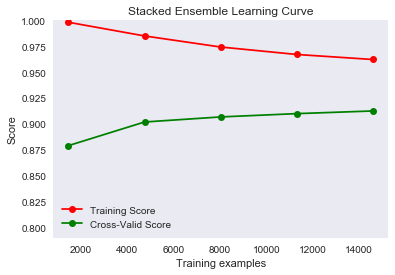

In [677]:
plot_learning_curves(
    'Stacked Ensemble Learning Curve',
    stacked_sizes, stacked_train_scores,
    stacked_valid_scores,
    (.79, 1.0)
)

In [ ]:
from mlxtend.regressor import StackingRegressor
en_alpha = [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1]

for i in en_alpha:
    lin_reg = LinearRegression()
    meta_reg_elastic = ElasticNet(alpha=en_alpha, l1_ratio=0.14, tol=0.00001, random_state=SEED)
    stacked_reg = StackingRegressor(regressors=[lgbm, gbm], meta_regressor = meta_reg_elastic)
    stacked_cv = cross_val_score(stacked_reg, kc_train, train_Y, cv=CV_FOLDS)
    print('Score:', i)
    print(stacked_cv.mean())

In [516]:
stacked_reg.fit(kc_train, train_Y)
pred = stacked_reg.predict(kc_test)

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
[LightGBM] [Info] Finished loading parameters
[LightGBM] [Info] Finished loading data in 0.165173 seconds
[LightGBM] [Info] Total Bins 4385
[LightGBM] [Info] Number of data: 16209, number of used features: 30
[LightGBM] [Info] Finished initializing training
[LightGBM] [Info] Started training...
[LightGBM] [Info] Trained a tree with leaves=35 and max_depth=8
[LightGBM] [Info] 0.007122 seconds elapsed, finished iteration 1
[LightGBM] [Info] Trained a tree with leaves=35 and max_depth=7
[LightGBM] [Info] 0.014130 seconds elapsed, finished iteration 2
[LightGBM] [Info] Trained a tree with leaves=35 and max_depth=8
[LightGBM] [Info] 0.020948 seconds elapsed, finished iteration 3
[LightGBM] [Info] Trained a tree with leaves=35 and max_depth=7
[LightGBM] [Info] 0.028058 seconds elapsed, finished iteration 4
[LightGBM] [Info] Trained a tree with leaves=

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
[LightGBM] [Info] Finished loading parameters
[LightGBM] [Info] Finished loading data in 0.023834 seconds
[LightGBM] [Info] Total Bins 3996
[LightGBM] [Info] Number of data: 1458, number of used features: 29
[LightGBM] [Info] Finished initializing training
[LightGBM] [Info] Started training...
[LightGBM] [Info] Trained a tree with leaves=35 and max_depth=7
[LightGBM] [Info] 0.004974 seconds elapsed, finished iteration 1
[LightGBM] [Info] Trained a tree with leaves=35 and max_depth=8
[LightGBM] [Info] 0.008331 seconds elapsed, finished iteration 2
[LightGBM] [Info] Trained a tree with leaves=35 and max_depth=8
[LightGBM] [Info] 0.011593 seconds elapsed, finished iteration 3
[LightGBM] [Info] Trained a tree

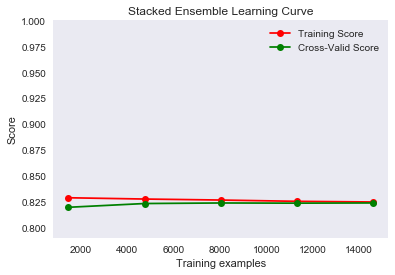

### Stacked - LGBM + XGB => Meta NN

In [12]:
stock_xgb = xgb.XGBRegressor()
meta_reg_nn = MLPRegressor(hidden_layer_sizes=80, random_state=SEED)
ensemble_tree = StackingRegressor([lgbm, gbm], meta_regressor=meta_reg_nn)
cv=cross_val_score(ensemble_tree, kc_train, train_Y, scoring='r2', cv=CV_FOLDS)

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable

In [652]:
cv.mean()
#0.90820085861641253
#0.91110763583595955
#0.91174523758452408

0.91167433292539335

In [35]:
stacked_sizes, stacked_train_scores, stacked_valid_scores = learning_curve(ensemble_tree, kc_train, train_Y, train_sizes=np.linspace(0.1, 1.0, 5.0, 10.0),scoring='r2', cv=CV_FOLDS)

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable

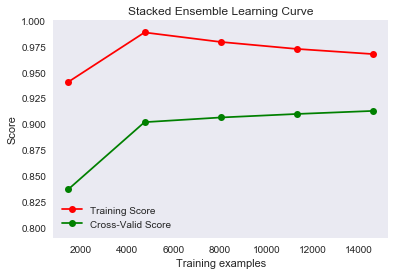

In [36]:
plot_learning_curves('Stacked Ensemble Learning Curve', stacked_sizes, stacked_train_scores, stacked_valid_scores, (.79, 1.0))

Though the stacked model featuring LGBM+GBM->Elastic Net seems to perform the best, the learning curve seems to indicate that training and validation scores do not optimally converge. It is very likely that more data is required for the model to converge, likely at an R2 score of .925. It seems that the choice of meta-learner benefits from having an algorithm that is vastly different than the input regressors.

In [14]:
from mlxtend.regressor import StackingRegressor
hl_sizes = range(80, 120, 5)
# max_iter = range(400, 2000, 200)
max_iter = [0.0003, 0.0006]

hl_high_score = 0
hl_value = 0


for i in max_iter:
    print('Size:', i)
    meta_reg_nn = MLPRegressor(
        hidden_layer_sizes=80,
        alpha=i,
        random_state=SEED)
    ensemble_tree = StackingRegressor([lgbm, gbm], meta_regressor=meta_reg_nn)
    cv=cross_val_score(ensemble_tree, kc_train, train_Y, scoring='r2', cv=CV_FOLDS)
    print('Score:', cv.mean())
    if cv.mean() > hl_high_score:
        hl_high_score = cv.mean()
        hl_value = i
        print('New high:', hl_high_score)
        print('High value:', hl_value)
        
# Value: 80
# Score: 0.912506090069
# New high: 0.912506090069
# High value: 80
# Value: 85
# Score: 0.911753729435
# Value: 90
# Score: 0.912323587275
# Value: 95
# Score: 0.912497705747
# Value: 100
# Score: 0.911786152492

# Value: 150
# Score: 0.912506090069
# New high: 0.912506090069
# High value: 150
# Size: 200
# Score: 0.912506090069
# Size: 250

# Value: 0.0001
# Score: 0.912506090069
# New high: 0.912506090069
# High value: 0.0001
# Size: 0.0003


Size: 0.0003
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environ